In [1]:
# 1. Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

print('Setup Complete!')

Setup Complete!


In [2]:
# 2. Load the dataset
url = "https://raw.githubusercontent.com/dsrscientist/dataset1/master/house_price_data.csv"
data = pd.read_csv(url)
data.head()

,Id,Sqft,Floor,TotalFloor,Bedroom,Living.Room,Bathroom,Price
0,1,1177.698,2,7,2,2,2,62000
1,2,2134.800,5,7,4,2,2,78000
2,3,1138.560,5,7,2,2,1,58000
3,4,1458.780,2,7,3,2,2,45000
4,5,967.776,11,14,3,2,2,45000


In [3]:
# 3. Data Exploration
data.info()

target = 'Price'
features = data.columns.drop([target])

data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 644
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id           645 non-null    int64  
 1   Sqft         645 non-null    float64
 2   Floor        645 non-null    int64  
 3   TotalFloor   645 non-null    int64  
 4   Bedroom      645 non-null    int64  
 5   Living.Room  645 non-null    int64  
 6   Bathroom     645 non-null    int64  
 7   Price        645 non-null    int64  
dtypes: float64(1), int64(7)
memory usage: 40.4 KB


,Id,Sqft,Floor,TotalFloor,Bedroom,Living.Room,Bathroom,Price
count,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000
mean,325.159690,1527.656260,5.939535,10.855814,2.837209,1.813953,1.810853,61986.823256
std,187.312152,767.386531,3.884721,4.996208,1.010740,0.462364,0.683574,35635.091007
min,1.000000,359.358000,1.000000,1.000000,1.000000,0.000000,0.000000,6100.000000
25%,164.000000,925.080000,3.000000,7.000000,2.000000,2.000000,1.000000,39000.000000
50%,326.000000,1423.200000,5.000000,12.000000,3.000000,2.000000,2.000000,50000.000000
75%,487.000000,1892.856000,8.000000,14.000000,4.000000,2.000000,2.000000,75000.000000
max,648.000000,5856.468000,22.000000,38.000000,7.000000,4.000000,5.000000,250000.000000


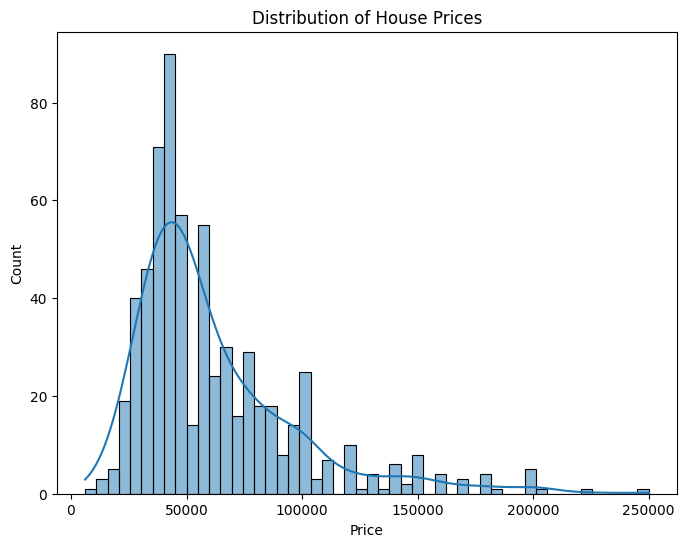

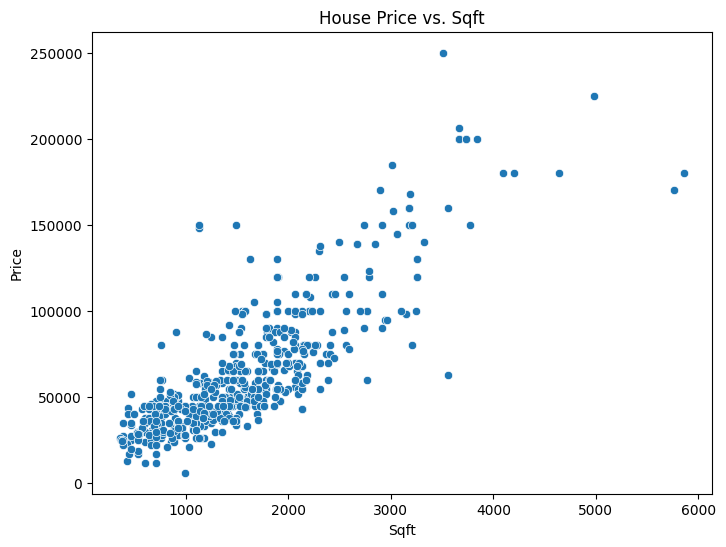

In [4]:
# Histogram for house prices
plt.figure(figsize=(8, 6))
sns.histplot(data['Price'], bins=50, kde=True)
plt.title('Distribution of House Prices')
plt.show()

# Scatter plot of Price vs Sqft
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['Sqft'], y=data['Price'])
plt.title('House Price vs. Sqft')
plt.show()

In [5]:
# 4. Handle missing values
# Example: Impute missing values with the median for numerical columns
num_features = data[features].select_dtypes(include=[np.number]).columns
cat_features = data[features].select_dtypes(include=[object]).columns

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

In [6]:
# 5. Split the data into training and testing sets
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# 6. Create and train the models
models = {
    "Linear Regression": Pipeline(steps=[('preprocessor', preprocessor),
                                         ('model', LinearRegression())]),
    "Random Forest": Pipeline(steps=[('preprocessor', preprocessor),
                                     ('model', RandomForestRegressor(random_state=42))]),
    "Gradient Boosting": Pipeline(steps=[('preprocessor', preprocessor),
                                         ('model', GradientBoostingRegressor(random_state=42))])
}


RuntimeError: `lowess=True` requires statsmodels, an optional dependency, to be installed.

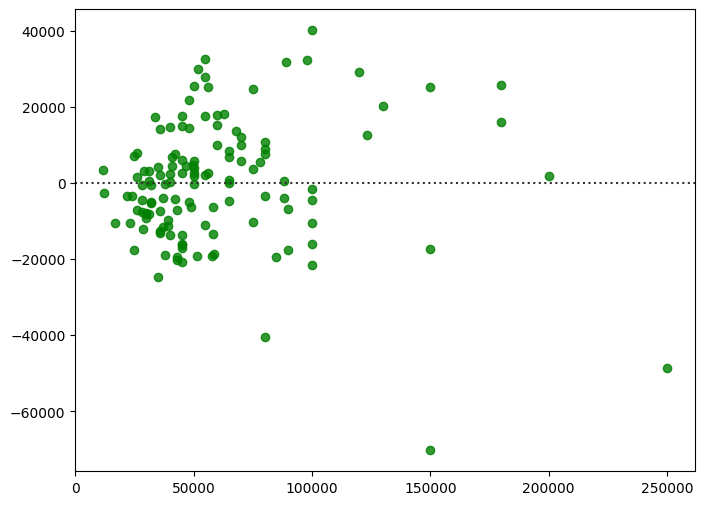

In [13]:
# 7. Evaluate the models
results = {}
for name, pipeline in models.items():
    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred),
        "Feature Importance": model.named_steps['model'].feature_importances_ if hasattr(model.named_steps['model'], 'feature_importances_') else None
    }
    # Residual plot for model evaluation
    plt.figure(figsize=(8, 6))
    sns.residplot(x=y_test, y=y_pred, lowess=True, color='g')
    plt.title(name)
    plt.xlabel('Actual Prices')
    plt.ylabel('Residuals')
    plt.show()

In [9]:
# 8. Display the results
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f" - MAE: {metrics['MAE']}")
    print(f" - MSE: {metrics['MSE']}")
    print(f" - R2: {metrics['R2']}")
    if metrics['Feature Importance'] is not None:
        importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': metrics['Feature Importance']
        }).sort_values(by='Importance', ascending=False)
        print(" - Feature Importance:\n", importance_df.head())
        # Plot feature importance from the Random Forest model
        importance_df.plot(kind='bar', x='Feature', y='Importance', title='Feature Importance')
        plt.show()
        


Linear Regression:
 - MAE: 13520.790854731442
 - MSE: 401068215.2501168
 - R2: 0.7205009707940984
Random Forest:
 - MAE: 11033.801472868217
 - MSE: 331132679.7772271
 - R2: 0.7692381021059814
 - Feature Importance:
       Feature  Importance
1        Sqft    0.794982
0          Id    0.063083
3  TotalFloor    0.051737
2       Floor    0.050304
4     Bedroom    0.021734
Gradient Boosting:
 - MAE: 12493.142366312051
 - MSE: 397900268.2559437
 - R2: 0.7227086703219578
 - Feature Importance:
       Feature  Importance
1        Sqft    0.845542
0          Id    0.047071
2       Floor    0.039955
3  TotalFloor    0.031257
4     Bedroom    0.019301


In [9]:
# 9. Final Conclusion
best_model_name = min(results, key=lambda k: results[k]["MAE"])
print(f"The best model is {best_model_name} with the lowest MAE of {results[best_model_name]['MAE']}")

The best model is Random Forest with the lowest MAE of 11033.801472868217


# Conclusion from the Results
#### Based on the results from the models, here’s a conclusion:
### 1. Model Performance
####	•	The Random Forest model performed the best among the three models with the lowest Mean Absolute Error (MAE) of approximately 11,034. This means that, on average, the Random Forest model’s predictions are off by about $11,034 when estimating house prices.
####	•	Gradient Boosting came second, with an MAE of around 12,493, and Linear Regression was the least accurate with an MAE of about 13,521.
####	•	The R-squared (R²) values indicate that all models explain a significant portion of the variance in house prices, with Random Forest again leading with an R² of 0.769.

### 2. Feature Importance Analysis:
####	•	Sqft (square footage) is the most important feature across both Random Forest and Gradient Boosting models, with importances of 0.795 and 0.846, respectively. This suggests that the size of the house (measured in square feet) is the most significant predictor of house prices in this dataset.
####	•	Other features like Id, Floor, TotalFloor, and Bedroom have much lower importance scores, indicating that they contribute less to predicting house prices.

## *How This Conclusion Was Derived:*
### 1.	Model Selection and Performance:
####	•	MAE (Mean Absolute Error) and R² (R-squared) are key metrics used to evaluate the model’s accuracy. Lower MAE indicates better performance, and higher R² indicates that the model explains more variance in the target variable.
####	•	The Random Forest model had the lowest MAE and the highest R², making it the best-performing model for this task. Thus, it’s chosen as the best model for predicting house prices.
###	2.	Feature Importance:
####	•	Feature Importance scores provided by Random Forest and Gradient Boosting highlight which features the model relied on most to make predictions.
####	•	Sqft (square footage) being the most important feature is logical because the size of the house is typically one of the primary factors influencing its price. The fact that this feature has a high importance score in both models reinforces its critical role.
###	3.	Less Important Features:
####	•	Features like Id, Floor, TotalFloor, and Bedroom have lower importance scores, which suggests that while they do contribute to the prediction, their impact is relatively small compared to Sqft.
####	•	The Id feature having some importance might be unexpected since it’s typically just an identifier, but it could be correlating with other important features or capturing some systematic pattern in the data.

## _Final Conclusion_
#### The Random Forest model is the most effective in predicting house prices in this dataset, with the lowest prediction error. The size of the house (Sqft) is the most significant factor influencing house prices, while other features like the number of floors or bedrooms play a smaller role. This insight could guide decisions in real estate, such as focusing on property size when evaluating or pricing homes.